## 2D Image Reconstruction using Context Encoders
### Deep Learning System Project (ENGR-E533)
##### By Mihir Patel, Vasudha Grover and Parth Rao

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import cv2

In [3]:
import glob
input_images = glob.glob('images/*.jpg')
print (len(input_images))

202599


Images


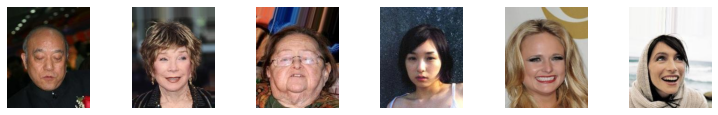

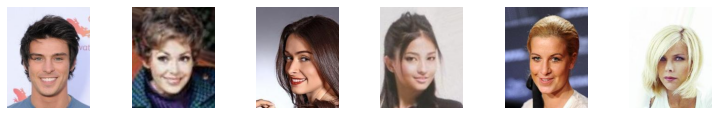

In [5]:
rows = 2
columns = 5
for column in range(rows):
    plt.figure(figsize=(13, 13))
    for column in range(columns):
        file = np.random.choice(input_images)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(660 + 1 + column)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

In [6]:
def generator_model():
    masked_image = tensorflow.keras.layers.Input(shape=(64, 64, 3))
    
    enc = masked_image
    
    enc = tensorflow.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(enc)
    
    enc = tensorflow.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(enc)
    
    enc = tensorflow.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(enc)
    
    enc = tensorflow.keras.layers.Conv2D(512, kernel_size=1, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.Dropout(0.5)(enc)
    
    dec = enc
    
    dec = tensorflow.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(dec)
    dec = tensorflow.keras.layers.Activation('relu')(dec)
    dec = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(dec)
    
    dec = tensorflow.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(dec)
    dec = tensorflow.keras.layers.Activation('relu')(dec)
    dec = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(dec)
    
    dec = tensorflow.keras.layers.Conv2D(3, kernel_size=3, padding='same')(dec)
    
    missing_image = tensorflow.keras.layers.Activation('tanh')(dec)
    
    return masked_image, missing_image

masked_image, missing_image = generator_model()
generator = tensorflow.keras.models.Model(inputs = masked_image, outputs = missing_image)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                             

In [7]:
def discriminator_model():
    input_image = tensorflow.keras.layers.Input(shape=(16, 16, 3))
    
    x = input_image
    
    x = tensorflow.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    
    x = tensorflow.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    
    x = tensorflow.keras.layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    
    x = tensorflow.keras.layers.Flatten()(x)
    
    disc_label = tensorflow.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return input_image, disc_label

input_image, disc_label = discriminator_model()
discriminator = tensorflow.keras.models.Model(inputs=input_image, outputs=disc_label)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                           

In [8]:
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

discriminator.trainable=False

gen_output = generator(masked_image)
disc_output = discriminator(gen_output)

gan_model = tensorflow.keras.models.Model(inputs = masked_image, outputs = [gen_output, disc_output])
gan_model.summary()

In [10]:
gan_model.compile(loss=['mse', 'binary_crossentropy'], optimizer = optimizer, loss_weights=[0.999, 0.001])

In [11]:
mask_size = 16
len_images = 5
y1 = np.random.randint(0, 64 - mask_size, len_images)
x1 = np.random.randint(0, 64 - mask_size, len_images)

def get_masked_images2(images, mask_size=16):
    y2 = y1 + mask_size
    x2 = x1 + mask_size
    
    masked_imgs = np.empty_like(images)
    missing_parts = np.empty((len(images), mask_size, mask_size, 3))
    for i, img in enumerate(images):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
        missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
        masked_img[_y1:_y2, _x1:_x2, :] = 0
        masked_imgs[i] = masked_img
    return masked_imgs, missing_parts, (y1, y2, x1, x2)  
        
def save_generator_results(generator,epoch_number,step_number):
    images = []
    file = input_images[90:95]
    for j in range(5):
        image = cv2.imread(file[j])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (64, 64))
        images.append((image-127.5)/127.5)
        
    masked_imgs, missing_parts, (y1s, y2s, x1s, x2s) = get_masked_images2(images)

    predicted_missing_parts = generator.predict_on_batch(masked_imgs)
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        y1, y2, x1, x2 = y1s[j], y2s[j], x1s[j], x2s[j]
        filled_image = images[j].copy()
        filled_image[y1:y2,x1:x2,:] = predicted_missing_parts[j]
        plt.subplot(550 + 1 + j)
        plt.imshow((filled_image+1.0)/2.0)
        plt.axis('off')
    plt.savefig("results/test_img_epoch" +str(epoch_number)+"_step"+str(step_number)+".png")
    plt.show()
    return 

def get_masked_images(images, mask_size=16):
    y1 = np.random.randint(0, images[0].shape[0] - mask_size, len(images))
    y2 = y1 + mask_size
    x1 = np.random.randint(0, images[0].shape[0] - mask_size, len(images))
    x2 = x1 + mask_size
    
    masked_imgs = np.empty_like(images)
    missing_parts = np.empty((len(images), mask_size, mask_size, 3))
    for i, img in enumerate(images):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
        missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
        masked_img[_y1:_y2, _x1:_x2, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs, missing_parts, (y1, y2, x1, x2)

def show_generator_results(generator):
    images = []
    for j in range(5):
        image = np.random.choice(input_images)
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (64, 64))
        images.append((image-127.5)/127.5)
        
    images_with_mask, missing_parts, (y1s, y2s, x1s, x2s) = get_masked_images(images)

    predicted_missing_parts = generator.predict_on_batch(images_with_mask)
    
    print ('Masked Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images_with_mask):
        plt.subplot(550 + 1 + j)
        plt.imshow((img+1.0)/2.0)
        plt.axis('off')
    plt.show()

    print ('Completed by Context Encoder')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        y1, y2, x1, x2 = y1s[j], y2s[j], x1s[j], x2s[j]
        filled_image = images[j].copy()
        filled_image[y1:y2,x1:x2,:] = predicted_missing_parts[j]
        plt.subplot(550 + 1 + j)
        plt.imshow((filled_image+1.0)/2.0)
        plt.axis('off')
    plt.savefig("hello.png")
    plt.show()
    
    print ('Original Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(550 + 1 + j)
        plt.imshow((img+1.0)/2.0)
        
        plt.axis('off')
    plt.show()

In [ ]:
epochs = 6
batch_size = 256
steps = 3400
loss_d_real_list = []
loss_d_fake_list = []
loss_d_list = []
loss_g_list = []

for i in range(0, epochs):
    for j in range(steps): 
        if j%200 == 0:
            save_generator_results(generator, i, j)
            show_generator_results(generator) 
            
        random_imgs = np.random.choice(input_images, size=batch_size)
        images = []
        for image in random_imgs:
            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (64, 64))
            images.append((image-127.5)/127.5)
        images = np.array(images)

        imgs_with_mask, missing_parts, _ = get_masked_images(images)

        fake_input = np.zeros((batch_size, 1))
        real_input = np.ones((batch_size, 1))
        
        fake_missing_parts = generator(imgs_with_mask)
        
        discriminator.trainable=True
        real_disc_loss = discriminator.train_on_batch(missing_parts, real_input)
        fake_disc_loss = discriminator.train_on_batch(fake_missing_parts, fake_input)
        
        real_disc_loss_list.append(real_disc_loss)
        fake_disc_loss_list.append(fake_disc_loss)
        
        disc_loss = (loss_d_real + loss_d_fake)/2
        disc_loss_list.append(disc_loss)
        
        discriminator.trainable=False

        gen_loss = gan_model.train_on_batch(imgs_with_mask,[missing_parts, real])
        gen_loss_list.append(gen_loss)
        
        if j%1700==0:
            filename = 'saved_model\gen_model'+"_epoch"+str(i)+"_step"+str(j)+".h5"
            generator.save(filename)
            
        if j%100 == 0:
            print ("Epoch:",i,", Step:",j,", D-Loss:",np.round(disc_loss[0], 3),", D-Acc:",np.round(disc_loss[1]*100),", G-Loss:", np.round(gen_loss[0]))            

Masked Images


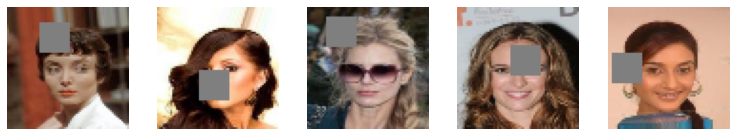

Completed by Context Encoder


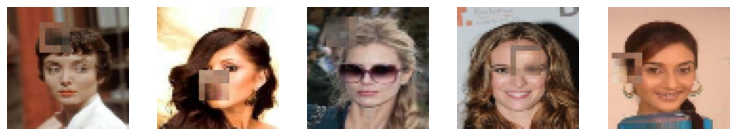

Original Images


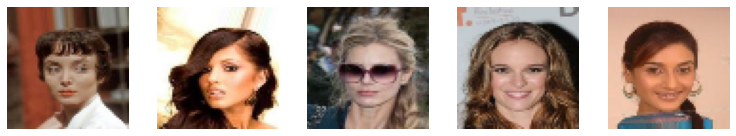

----------------------------------------------------------------------------------------------------
Masked Images


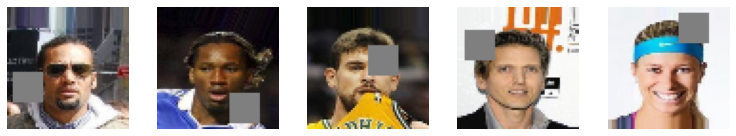

Completed by Context Encoder


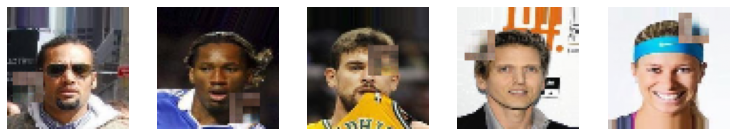

Original Images


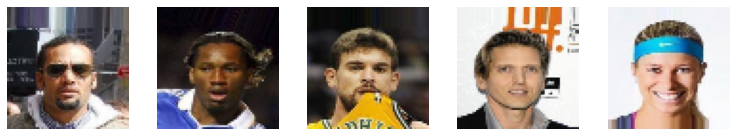

----------------------------------------------------------------------------------------------------


In [14]:
for i in range(2):
    show_generator_results(generator_network) 
    print ("-"*100)

Reference:
https://github.com/kartikgill/TF2-Keras-GAN-Notebooks/blob/main/context-encoder/Context-Encoder-TF2.ipynb